<a href="https://colab.research.google.com/github/ArmaanMistry/pytorch-learning/blob/main/04_pytorch_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import make_circles

# Making 1000 samples
n_samples = 1000

# Creating Circles
X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [ ]:
print(f"First 5 X features: \n{X[:5]}")
print(f"\nFirst 5 y features:\n{y[:5]}")

First 5 X features: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y features:
[1 1 1 1 0]


In [ ]:
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0], "X2" : X[:, 1], "label" : y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [ ]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

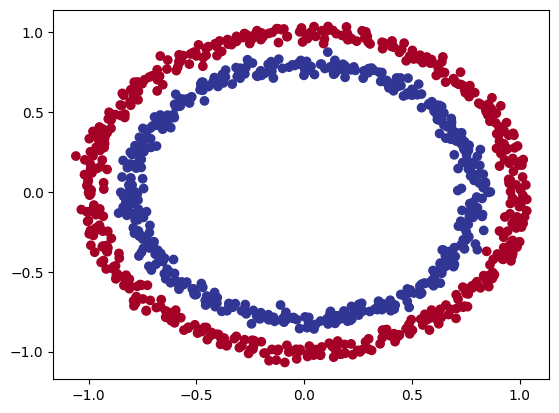

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.RdYlBu);
plt.show()

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# Turning data into tensors and crat train and tst splits
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

In [ ]:
model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
untrained_preds = model_0(X_test.to(device))
print(f"First 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 y_test (test labels)\n{y_test[:10]}")

First 10 predictions: 
tensor([[-0.0015],
        [-0.1381],
        [ 0.1028],
        [-0.0300],
        [-0.2999],
        [-0.3802],
        [-0.4456],
        [-0.5033],
        [ 0.1197],
        [-0.1517]], grad_fn=<SliceBackward0>)

First 10 y_test (test labels)
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.0015],
        [-0.1381],
        [ 0.1028],
        [-0.0300],
        [-0.2999]], grad_fn=<SliceBackward0>)

In [ ]:
y_logits.shape

torch.Size([200, 1])

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4996],
        [0.4655],
        [0.5257],
        [0.4925],
        [0.4256]], grad_fn=<SliceBackward0>)

In [ ]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))

print(torch.eq(y_preds[:5].squeeze(), y_pred_labels[:5].squeeze()))

tensor([True, True, True, True, True])


In [ ]:
print(y_preds[:5].squeeze())
print(f"\n{y_test[:5]}")

tensor([0., 0., 1., 0., 0.], grad_fn=<SqueezeBackward0>)

tensor([1., 0., 1., 0., 1.])


In [ ]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # Forward Pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss
  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  # Optimize zero grad
  optimizer.zero_grad()

  # Loss Backwards
  loss.backward()

  # Optimizer Step
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward Pass
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # Calculate the loss
    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true = y_test, y_pred = test_preds)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70313, Accuracy: 48.25% | Test loss: 0.69838, Test acc: 49.50%
Epoch: 10 | Loss: 0.70028, Accuracy: 48.75% | Test loss: 0.69619, Test acc: 49.50%
Epoch: 20 | Loss: 0.69859, Accuracy: 49.00% | Test loss: 0.69504, Test acc: 50.50%
Epoch: 30 | Loss: 0.69744, Accuracy: 49.38% | Test loss: 0.69438, Test acc: 48.50%
Epoch: 40 | Loss: 0.69660, Accuracy: 49.75% | Test loss: 0.69396, Test acc: 48.50%
Epoch: 50 | Loss: 0.69595, Accuracy: 49.88% | Test loss: 0.69369, Test acc: 48.00%
Epoch: 60 | Loss: 0.69543, Accuracy: 50.12% | Test loss: 0.69351, Test acc: 47.50%
Epoch: 70 | Loss: 0.69501, Accuracy: 50.25% | Test loss: 0.69340, Test acc: 47.00%
Epoch: 80 | Loss: 0.69467, Accuracy: 50.00% | Test loss: 0.69334, Test acc: 48.00%
Epoch: 90 | Loss: 0.69438, Accuracy: 50.00% | Test loss: 0.69331, Test acc: 48.50%


In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

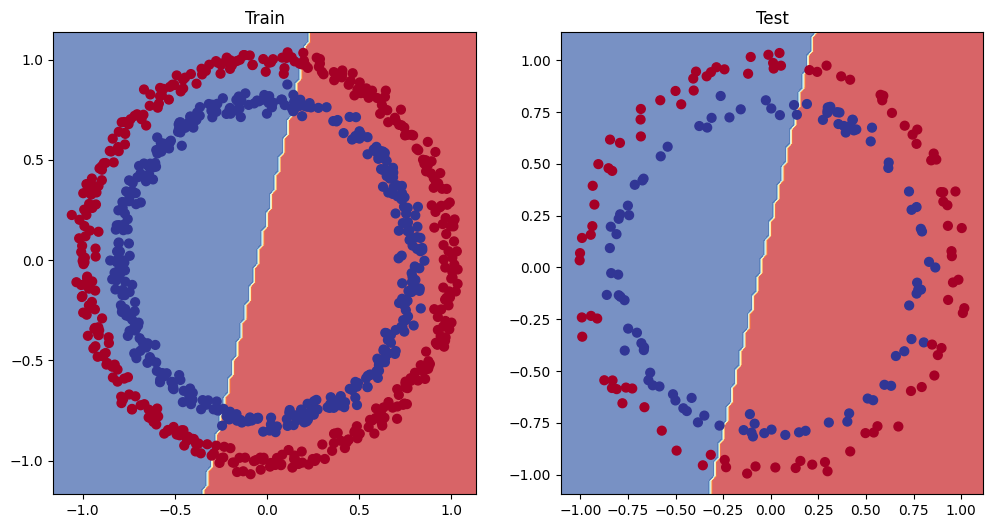

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [ ]:
from torch import nn
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [ ]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

   # Forward Pass
   y_logits = model_1(X_train).squeeze()
   y_pred = torch.round(torch.sigmoid(y_logits))

   # Calculate the loss
   loss = loss_fn(y_logits, y_train)
   acc = accuracy_fn(y_true = y_train, y_pred = y_pred)


   # Optimize zero grad
   optimizer.zero_grad()

  # Loss Backwards
   loss.backward()

  # Optimizer Step
   optimizer.step()

  # Testing
   model_1.eval()
   with torch.inference_mode():

    # Forward Pass
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # Calculate the loss
    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true = y_test, y_pred = test_preds)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test loss: 0.62145, Test acc: 79.00%


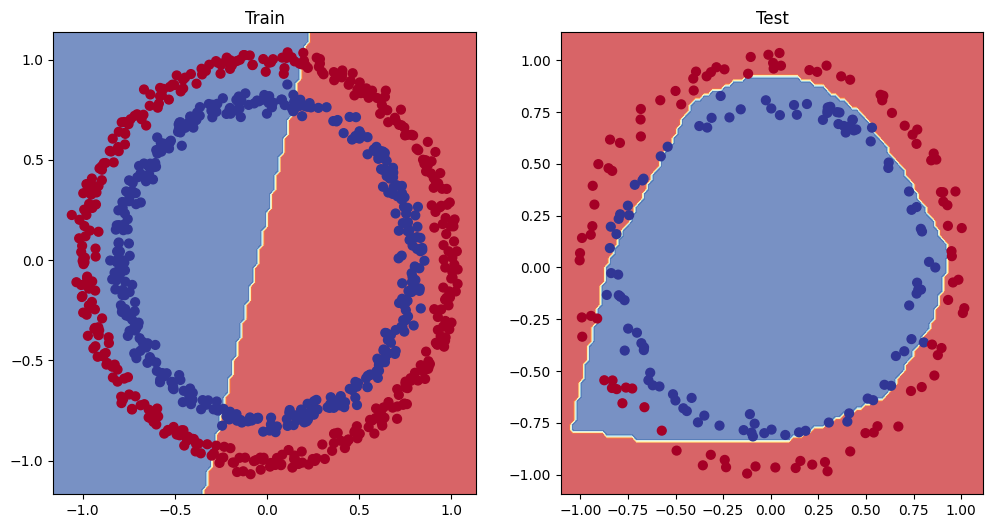

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) # model_3 = has non-linearity

# Crating multi-class Classification

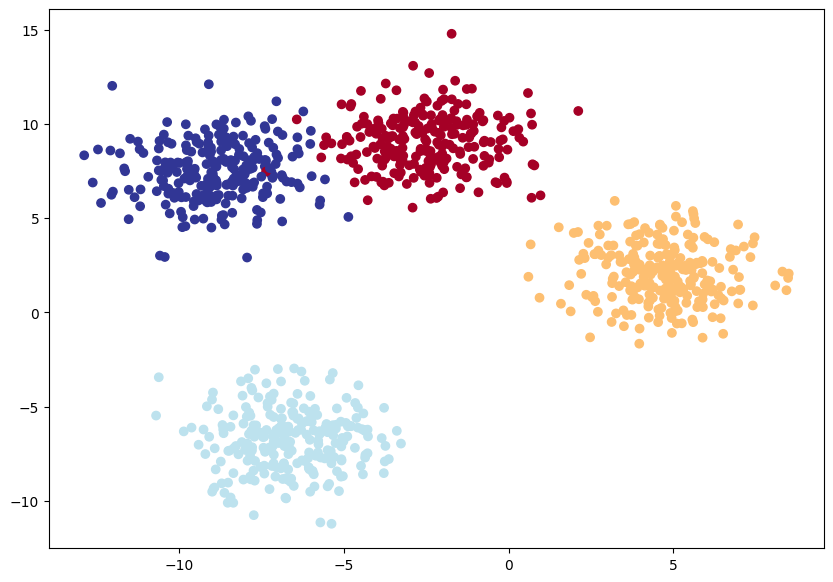

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = 42)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size = 0.2, random_state = 42)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap = plt.cm.RdYlBu);

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
from torch import nn
